# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
18272,26031,70983,Somewhere Playing the Ponies,25-03-2020,"Gov Cuomo:""Trump not getting the much needed v...",Negative
10627,16689,61641,Mid Ohio Valley,21-03-2020,In Phase One we wanted to focus our attention...,Positive
15121,22192,67144,"Alexandria, VA",23-03-2020,Reporters in the WH briefing room are sitting ...,Negative
6213,11333,56285,"Melbourne, Australia",19-03-2020,Has the Reserve Bank lost control of the econo...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [ ]:
# Преобразование целевой переменной в бинарную
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if 'Positive' in x else 0)

In [ ]:
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
20131,28348,73300,"Austin, TX",26-03-2020,We were curious how HEB managed to be so prepa...,1
10588,16641,61593,"San Francisco, CA",21-03-2020,?BEWARE OF VIRUS ROBOCALLS\r\r\nI wish I could...,1
17234,24772,69724,Switzerland,25-03-2020,Total calm at the Swiss supermarket this morni...,1
14363,21243,66195,"Tempe, AZ",23-03-2020,I wrote a thing reflecting on c virus and grie...,0


Сбалансированы ли классы?

In [ ]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** Классы сбалансированы, разница между представителями положительных и отрицательных твитов невелика.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
# Проверка пропусков в данных
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
# Заполнение пропусков в фиче Location и последующая проверка отсутствия пропусков
df.fillna('Unknown', inplace=True)
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
from collections import Counter

token_counts = Counter()
tweets = train['OriginalTweet']

# Деление твитов на токены по пробелам и преобразование их к нижнему регистру
for tweet in tweets:
    tokens = tweet.lower().split()
    token_counts.update(tokens)

Какой размер словаря получился?

In [ ]:
len(token_counts)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
token_counts.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Большую часть топа токенов занимают стоп-слова, то есть слова, которые встречаются почти в любом твите и не говорят ничего интересного о конкретном твите - это шум. Единственный токен, который может быть интересен - это #coronavirus, однако и этот токен характеризует общую тематику твитов и вряд ли поможет для определения эмоциональной окраски твита.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
from nltk.corpus import stopwords

# Загрузка английских стоп слов
nltk.download("stopwords", quiet=True)
noise = stopwords.words('english')
# Удаление стоп слов из словаря токенов
token_counts = Counter({token: count for token, count in token_counts.items() if token not in noise})

In [ ]:
token_counts.most_common(10)

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:** Новый топ токенов теперь не содержит шумовых стоп-слов. Теперь самые популярные токены связаны с общей тематикой твитов - короновирус и его последствия - изменения цен, еда, магазины, супермаркеты, люди и т.д. Кроме того в топ токенов попадают хэштеги тематики короновируса: #covid19, #coronavirus. Единственный токен, который не несет никакой информации для определения эмоциональной окраски твита - HTML тэг &amp

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
token_counts.most_common()[-20:]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** Эти токены непопулярны, так как они специфичные и узконаправленные, они являются уникальными для некоторых твитов. Кроме того, многие из этих токенов необработаны - в них присутствуют знаки препинания, уникальные символы, ссылки. Необходимо их обработать и привести к более общему виду, так как в них может содержаться важная для эмоциональной окраски информация.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

# Инициализируем твит токенайзер
tweet_tokenizer = TweetTokenizer()
token_counts = Counter()
# Берем твиты тестовой части
tweets = train['OriginalTweet']

# Токенизируем твиты
for tweet in tweets:
    tokens = tweet_tokenizer.tokenize(tweet.lower())
    token_counts.update(tokens)

In [ ]:
token_counts.most_common(10)

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** TweetTokenizer лучше работает с твитами, он отделяет знаки препинания, скобочки и другие спецсимволы, характерные для твитов, которые могут нести информацию об эмоциональной окраске твита, в отличие от обычного токенайзера по сплитам пробелов, который не выделяет спецсимволы и знаки препинания, если они не отделены от слова пробелом.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

# Добавляем в шумовой список стоп-слова и знаки пунктуации
noise = stopwords.words('english') + list(punctuation)
# Удаляем из словаря токенов шум
token_counts = Counter({token: count for token, count in token_counts.items() if token not in noise})

In [ ]:
token_counts.most_common(10)

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** Теперь в топ токенов кроме тематических слов о коронавирусе входят спецсимволы, такие как: \x92, â, \x82. Они не похожи на слова и возможно являются символами таблицы Unicode.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
token_counts = Counter({token: count for token, count in token_counts.items() if len(token) > 1 or ord(token) < 128})

In [ ]:
token_counts.most_common(10)

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [ ]:
token_counts.most_common()[-20:]

[('https://t.co/lw1r0rm7xs', 1),
 ('https://t.co/5cbliqzx7l', 1),
 ('now.when', 1),
 ('milion', 1),
 ('skellig', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã', 1),
 ('renewing', 1),
 ('flew', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** Теперь в топе популярных токенов слово covid-19 разделено на два отдельных токена, убран тег &amp, общая тематика коронавируса сохранилась в топе популярности. В топе самых непопулярных токенов добавилось больше ссылок и хэштегов, убрались токены, которые содержали знаки препинания. Лучше стало то, что теперь в твитах мы можем отслеживать спецсимволы - например, улыбающиеся или грустные скобочки, которые не были отделены пробельным токенайзером, мы можем лучше сфокусироваться на тематике твитов. Хуже стало то, что некоторые слова по типу covid-19 теперь являются двумя разными токенами, хотя отдельно токен 19 не несет смысловой нагрузки, учитывая тематику коронавируса.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
hashtag_counts = Counter({token: count for token, count in token_counts.items() if token.startswith('#')})

In [ ]:
hashtag_counts.most_common(10)

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** Все эти хэштеги несут примерно одинаковую информацию о тематике твитов - коронавирус, ковид, пандемия, социальная дистанция. Хэштеги довольно популярны.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
url_counts = Counter({token: count for token, count in token_counts.items() if token.startswith('https://t.co')})

In [ ]:
url_counts.most_common(10)

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** Популярность ссылок значительно ниже, чем популярность хэштегов, так как каждая ссылка уникальна и ведет на специфичный контент, имеет низкую обобщающую способность. Информация о ссылке на страницу бесполезна.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):
    tweet_tokenizer = TweetTokenizer()
    tokens = tweet_tokenizer.tokenize(text.lower())
    noise = stopwords.words('english') + list(punctuation)

    tokens = [token for token in tokens
              if token not in noise
              and (len(token) > 1 or ord(token) < 128)
              and not token.startswith('https://t.co')]

    return tokens


In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Инициализируем векторайзер с кастомным токенайзером
cv = CountVectorizer(tokenizer=custom_tokenizer)
# Инициализируем твиты train части датасета
tweets_train = train['OriginalTweet']
# Применяем векторайзер к твитам
X_train = cv.fit_transform(tweets_train)

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** В начальном словаре было 79755 токенов, теперь имеем 45308, что практически в 2 раза меньше.

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
test_tweet = [train.iloc[ind]['OriginalTweet']]
# Векторизуем тестовый твит
X_test = cv.transform(test_tweet)
# Получаем важность токенов
df_test_tweet = pd.DataFrame(X_test.toarray(), columns=cv.get_feature_names_out())
df_non_zero = df_test_tweet.loc[:, (df_test_tweet != 0).any(axis=0)]
df_non_zero

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Ответ:** Заметим, что среди ненулевых токенов по встречаемости в тексте остались только токены, которые встречаются в этом тексте по 1 разу, то есть среди них невозможно выделить самый важный токен и самый неважный токен, так как у всех токенов компонента равна 1.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Инициализируем TfidfVectorizer с кастомным токенайзером
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
tweets_train = train['OriginalTweet']
# Применяем векторайзер на трейн части твитов датасета
X_train_tfidf = tfidf_vec.fit_transform(tweets_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
test_tweet = [train.iloc[ind]['OriginalTweet']]
X_test_tfidf = tfidf_vec.transform(test_tweet)

df_test_tweet = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vec.get_feature_names_out())
df_non_zero = df_test_tweet.loc[:, (df_test_tweet != 0).any(axis=0)]
df_non_zero

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
0,0.225843,0.168252,0.310426,0.386764,0.324474,0.113289,0.320473,0.301211,0.254273,0.163067,0.147595,0.255006,0.354346,0.244065


In [ ]:
max_value = df_non_zero.max().max()
max_token = df_non_zero.max().idxmax()

min_value = df_non_zero.min().min()
min_token = df_non_zero.min().idxmin()

print(f'Самый важный токен: {max_token} со значением TF-IDF {max_value}')
print(f'Самый неважный токен: {min_token} со значением TF-IDF {min_value}')

Самый важный токен: brainless со значением TF-IDF 0.3867641170466375
Самый неважный токен: food со значением TF-IDF 0.11328893069250721


**Ответ:** Теперь самые важные и неважные токены определились хорошо, потому что TF-IDF характеризует важность слова для конкретного текста: чем чаще данное слово встречается в данном тексте и чем реже в остальных, тем оно важнее для данного текста. Слово brainless - скорбительное, характеризует негативный отзыв, встречается в данном тексте 1 раз, но редко встречается в остальных текстах Train части, а слово food достаточно часто встречается в остальных текстах, следовательно оно менее важно для данного текста, оно не так сильно его характеризует.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'great' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
4066,8742,53694,"Adelaide, South Australia",18-03-2020,BREAKING: WeÃÂre giving supermarkets the opt...,1
342,4219,49171,"Boston, MA",16-03-2020,[THREAD] China's role in wildlife trade should...,1
21883,30511,75463,London,02-04-2020,Coronavirus career pivots: 'I now work in a su...,1
23519,32529,77481,"Moulton, England",05-04-2020,Well done James great front of store before we...,1
...,...,...,...,...,...,...
21960,30608,75560,Unknown,02-04-2020,@dino_melaye I commend your efforts so far in ...,1
23905,33018,77970,Unknown,05-04-2020,Absolutely brilliant idea amp a great use of a...,1
25907,35528,80480,Bay Area,07-04-2020,Afraid of tracking in the #coronavirus? Here a...,1
18987,26911,71863,Unknown,25-03-2020,@AmyPoythress I hope you &amp; your family rem...,1


In [ ]:
ind = 23905
test_tweet = [train.loc[ind]['OriginalTweet']]
X_test_tfidf = tfidf_vec.transform(test_tweet)

df_test_tweet = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vec.get_feature_names_out())
df_non_zero = df_test_tweet.loc[:, (df_test_tweet != 0).any(axis=0)]
df_non_zero

,19,absolutely,amp,brilliant,care,crisis,endless,etc,free,gift,...,hospital,idea,list,mean,much,post,show,supermarket,use,workers
0,0.085575,0.259189,0.179137,0.296693,0.196072,0.159202,0.321042,0.208685,0.189624,0.269845,...,0.232834,0.237303,0.223796,0.240497,0.187952,0.217295,0.236476,0.109901,0.182643,0.150058


In [ ]:
test_tweet

['Absolutely brilliant idea amp a great use of a free gift from An Post Show how much your hospital care home supermarket etc the list is endless workers mean to you during this 19 crisis']

In [ ]:
max_value = df_non_zero.max().max()
max_token = df_non_zero.max().idxmax()

min_value = df_non_zero.min().min()
min_token = df_non_zero.min().idxmin()

print(f'Самый важный токен: {max_token} со значением TF-IDF {max_value}')
print(f'Самый неважный токен: {min_token} со значением TF-IDF {min_value}')

Самый важный токен: endless со значением TF-IDF 0.3210416218449363
Самый неважный токен: 19 со значением TF-IDF 0.08557488947198498


**Ответ:** TF-IDF выделяет важный токен endless - бесконечный, что может характеризовать положительно окрашенный твит, так как в первую очередь слово бесконечный ассоциируется с бесконечной благодарностью работникам, бесконечным списком людей, которые работают во время коронавируса ради комфортной жизни других людей. Оно редко встречается в других текстах, но хорошо характеризует данный твит, в отличие от токена 19, который встречается в этом тексте и очень часто встречается в остальных текстах.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
tweets_train = train['OriginalTweet']
tweets_test = test['OriginalTweet']
# Выделение целевой переменной
y_train = train['Sentiment']
y_test = test['Sentiment']
# Инициализация векторайзеров
cv = CountVectorizer(tokenizer=custom_tokenizer)
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
# Обучание и применение векторайзеров к трейн части твитов датасета
# Применение векторайзера к тест части твитов датасета
X_train_cv = cv.fit_transform(tweets_train)
X_test_cv = cv.transform(tweets_test)

X_train_tfidf = tfidf_vec.fit_transform(tweets_train)
X_test_tfidf = tfidf_vec.transform(tweets_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Инициализация и обучение логистической регрессии на CV векторизованных данных
logreg_cv = LogisticRegression()
logreg_cv.fit(X_train_cv, y_train)

print(f'Accuracy on Train with CV: {accuracy_score(y_train, logreg_cv.predict(X_train_cv))}')
print(f'Accuracy on Test with CV: {accuracy_score(y_test, logreg_cv.predict(X_test_cv))}')

Accuracy on Train with CV: 0.9844510892780863
Accuracy on Test with CV: 0.8674506677297189


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Инициализация и обучение логистической регрессии на Tfidf векторизованных данных
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(X_train_tfidf, y_train)

print(f'Accuracy on Train with tfidf: {accuracy_score(y_train, logreg_tfidf.predict(X_train_tfidf))}')
print(f'Accuracy on Test with tfidf: {accuracy_score(y_test, logreg_tfidf.predict(X_test_tfidf))}')

Accuracy on Train with tfidf: 0.9254592054677488
Accuracy on Test with tfidf: 0.8533984452860275


**Ответ:**Лучший результат показал обычный CountVectorizer.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer

In [ ]:
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tweet_tokenizer = TweetTokenizer()
  tokens = tweet_tokenizer.tokenize(text.lower())
  noise = stopwords.words('english') + list(punctuation)

  tokens = [stemmer.stem(token) for token in tokens
            if token not in noise
            and (len(token) > 1 or ord(token) < 128)
            and not token.startswith('https://t.co')]

  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
# Инициализация CV векторайзера с кастомным токенайзером со стеммингом
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)

X_train = cv.fit_transform(tweets_train)

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


In [ ]:
# Инициализируем TfidfVectorizer с кастомным токенайзером со стеммингом
tfidf_vec = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

# Применяем векторайзер на трейн части твитов датасета
X_train_tfidf = tfidf_vec.fit_transform(tweets_train)

print(len(tfidf_vec.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


37021


**Ответ**: Размер словаря уменьшился, убрались лишние токены, которые отличались друг от друга окончаниями, суффиксами и другими частями слов, которые не несли информации.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
# Инициализация векторайзеров
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_vec = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
# Применение векторайзеров
X_train_cv = cv.fit_transform(tweets_train)
X_test_cv = cv.transform(tweets_test)

X_train_tfidf = tfidf_vec.fit_transform(tweets_train)
X_test_tfidf = tfidf_vec.transform(tweets_test)

In [ ]:
logreg_cv = LogisticRegression()
logreg_cv.fit(X_train_cv, y_train)

print(f'Accuracy on Train with CV: {accuracy_score(y_train, logreg_cv.predict(X_train_cv))}')
print(f'Accuracy on Test with CV: {accuracy_score(y_test, logreg_cv.predict(X_test_cv))}')

Accuracy on Train with CV: 0.9717642033319095
Accuracy on Test with CV: 0.8674506677297189


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(X_train_tfidf, y_train)

print(f'Accuracy on Train with tfidf: {accuracy_score(y_train, logreg_tfidf.predict(X_train_tfidf))}')
print(f'Accuracy on Test with tfidf: {accuracy_score(y_test, logreg_tfidf.predict(X_test_tfidf))}')

Accuracy on Train with tfidf: 0.9158906450234943
Accuracy on Test with tfidf: 0.8560892963922663


**Ответ:** Стемминг практически не изменил качество в моделях, при CV качество на тесте не изменилось, на трейне немного упало. При TF-IDF качество на трейне немного упало, на тесте немного улучшилось, но изменения незначительны, нет смысла использовать стемминг.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(
                            tweets_train
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** Параметр, ограничивающий максимульную частоту встречаемости токена в документах получился маленьким, так как у нас большое число токенов с низкой частотой.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00043
                        ).fit(
                            tweets_train
                            )
print(len(cv_df.vocabulary_))

3700


**Ответ:** Значением min_df получилось очень низким, следовательно, большая часть токенов имеет очень маленькую частоту встречаемости в документах.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import StandardScaler
skaler = StandardScaler()
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00043)
# Векторизирование признаков
X_train = cv_df.fit_transform(tweets_train)
X_test = cv_df.transform(tweets_test)
# Скалирование признаков
X_train_scaled = skaler.fit_transform(X_train.toarray())
X_test_scaled = skaler.transform(X_test.toarray())

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

print(f'Accuracy on Train with CV min_df: {accuracy_score(y_train, logreg.predict(X_train_scaled))}')
print(f'Accuracy on Test with CV min_df: {accuracy_score(y_test, logreg.predict(X_test_scaled))}')

Accuracy on Train with CV min_df: 0.9416915847928236
Accuracy on Test with CV min_df: 0.8446282639027307


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


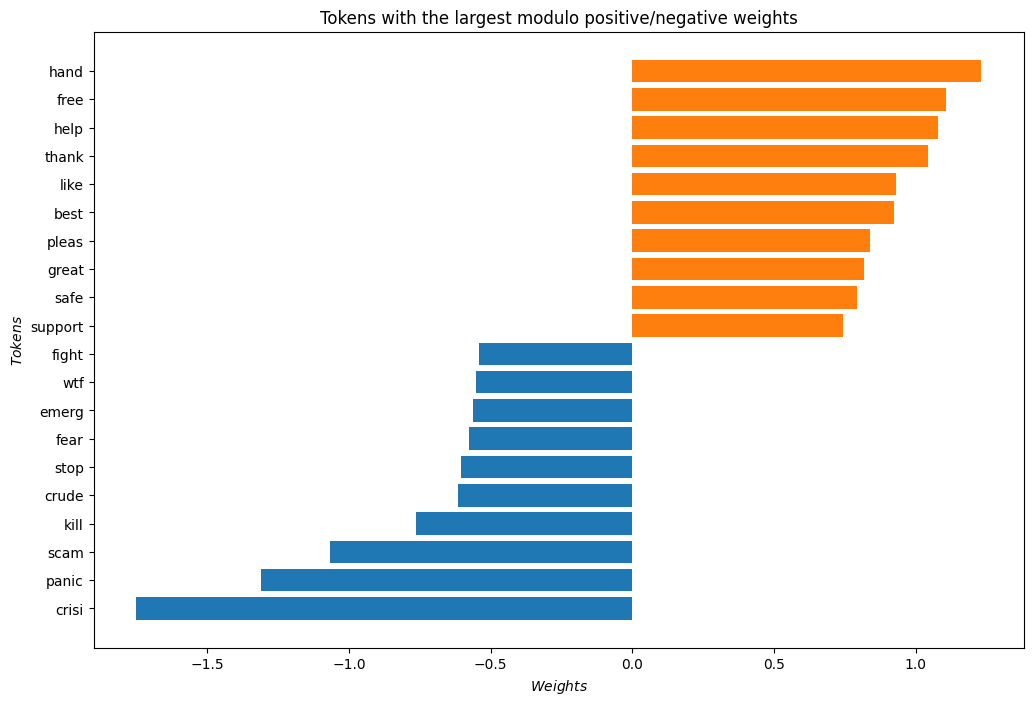

In [ ]:
coefs = logreg.coef_[0]
tokens = cv_df.get_feature_names_out()

min_tokens = tokens[np.argsort(coefs)[:10]]
max_tokens = tokens[np.argsort(coefs)[-10:]]

plt.figure(figsize=(12, 8))
plt.title('Tokens with the largest modulo positive/negative weights')
plt.barh(min_tokens, coefs[np.argsort(coefs)[:10]])
plt.barh(max_tokens, coefs[np.argsort(coefs)[-10:]])
plt.xlabel('$Weights$')
plt.ylabel('$Tokens$')
plt.show()

**Ответ:** Эти токены в наибольшей степени характерны для положительно/отрицательно окрашенных твитов.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


In [ ]:
value_counts = df['UserName'].value_counts()
value_counts[value_counts > 1]

Series([], Name: count, dtype: int64)

In [ ]:
value_counts = df['ScreenName'].value_counts()
value_counts[value_counts > 1]

Series([], Name: count, dtype: int64)

**Ответ:** UserName - имя пользователя (целое число), ScreenName - отображающееся имя пользователя (целое число), это просто уникальные идентификаторы пользователей. Кроме того, можно заметить, что записи пользователей не повторялись, следовательно можно отбросить гипотезу, что какие-то пользователи спамили только негативными/позитивными твитами. Эти признаки бесполезны, нет смысла их добавлять к матрице с отскалированными признаками.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

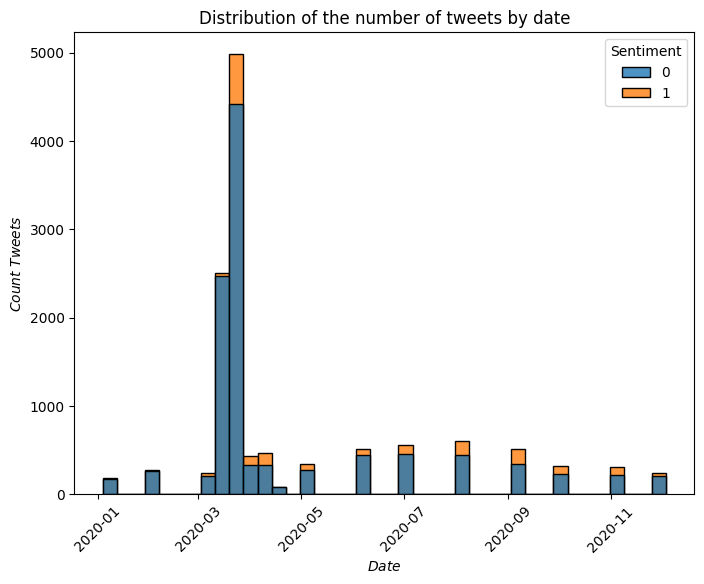

In [ ]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='mixed')

plt.figure(figsize=(8, 6))
plt.title('Distribution of the number of tweets by date')
sns.histplot(x='TweetAt', data=train, hue='Sentiment', bins=40, alpha=0.8)
plt.xticks(rotation=45)
plt.ylabel("$Count$ $Tweets$")
plt.xlabel("$Date$")
plt.show()

**Ответ:** Этот признак бесполезный, так как из распределения количества твитов по эмоциональной окраске в зависимости от даты твита видно, что на протяжении всего времени количества позитивных и негативных твитов в зависимости от даты были примерно одинаковыми.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
train['Location'].value_counts()

Location
Unknown                           4944
London                             301
United States                      295
London, England                    274
New York, NY                       223
                                  ... 
Work: Kent and Live: Sussex          1
Somewhere on TradingView             1
Honolulu, Hawai?i                    1
SFO                                  1
Waterville, Ireland Austin, TX       1
Name: count, Length: 7949, dtype: int64

__Ответ__: Всего 7949 уникальных значений категорий.

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

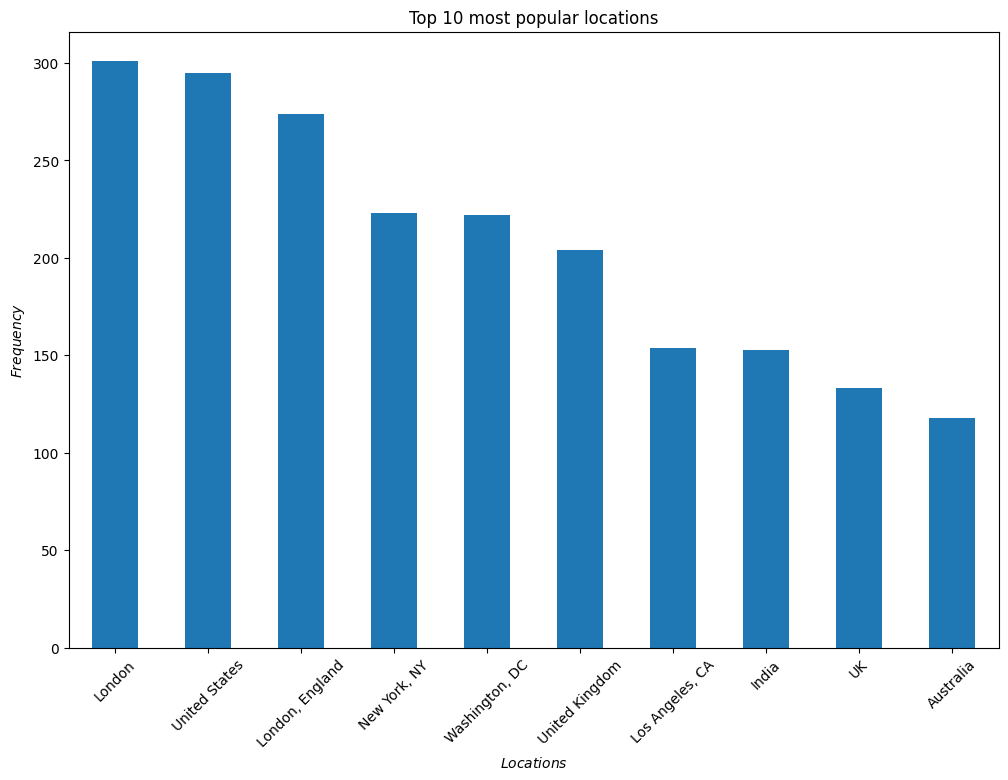

In [ ]:
top_locations = train['Location'].value_counts().drop('Unknown').head(10)

plt.figure(figsize=(12,8))
top_locations.plot(kind='bar')
plt.title('Top 10 most popular locations')
plt.xticks(rotation=45)
plt.xlabel('$Locations$')
plt.ylabel('$Frequency$')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

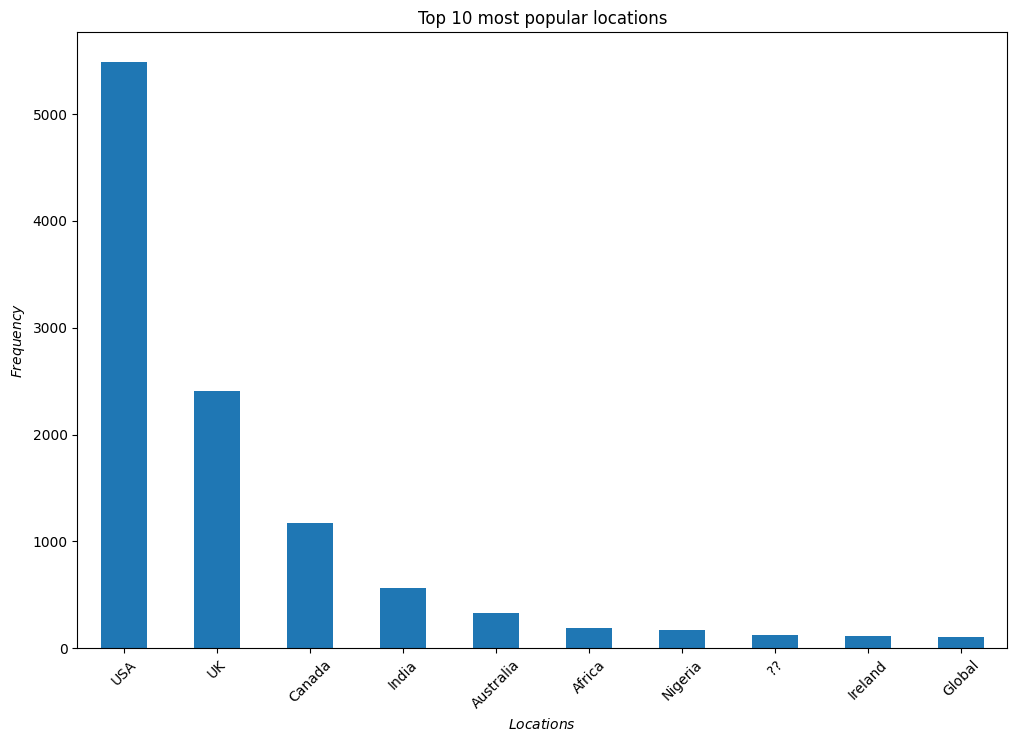

In [ ]:
train['WiderLocation'] = train['Location'].str.split(',').str[-1].str.split().str[-1].str.strip()
test['WiderLocation'] = test['Location'].str.split(',').str[-1].str.split().str[-1].str.strip()


UK = ["England", "Scotland", "Wales", "Northern Ireland", "London", "Great Britain", "United Kingdom", "uk", "Kingdom"]
USA = ["US", "us", "usa" "United States", "States"] + ["AL", "AK", "AZ", "AR", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS",
                                 "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM",
                                 "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA",
                                 "WA", "WV", "WI", "WY", "AS", "DC", "GU", "MP", "PR", "VI"] + [state_name for state_name in
                                 ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut",
                                  "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
                                  "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan",
                                  "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire",
                                  "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma",
                                  "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee",
                                  "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming", "York"]]
Canada = ["Ontario", "CA"]

replace_dict = {**{country: 'UK' for country in UK}, **{country: 'USA' for country in USA}, **{country: 'Canada' for country in Canada}}

train['WiderLocation'] = train['WiderLocation'].replace(replace_dict)
test['WiderLocation'] = test['WiderLocation'].replace(replace_dict)

top_locations = train['WiderLocation'].value_counts().drop('Unknown').head(10)

plt.figure(figsize=(12,8))
top_locations.plot(kind='bar')
plt.title('Top 10 most popular locations')
plt.xticks(rotation=45)
plt.xlabel('$Locations$')
plt.ylabel('$Frequency$')
plt.show()

In [ ]:
train['WiderLocation'].value_counts()

WiderLocation
USA        5490
Unknown    4947
UK         2407
Canada     1174
India       560
           ... 
33131         1
ÃÂUSA       1
always        1
10012         1
NIGERIA       1
Name: count, Length: 2963, dtype: int64

__Ответ__: Теперь 2963 уникальных категории.

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
from sklearn.preprocessing import OneHotEncoder

count_locations = train['WiderLocation'].value_counts()
most_common_locations = count_locations[count_locations > 1].index.tolist()

ohe = OneHotEncoder(categories=[most_common_locations], handle_unknown='ignore', sparse=False) # sparse=False

train_enc = ohe.fit_transform(train[['WiderLocation']])
test_enc = ohe.transform(test[['WiderLocation']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
count_locations[count_locations > 1]

WiderLocation
USA         5490
Unknown     4947
UK          2407
Canada      1174
India        560
            ... 
one.           2
Mi             2
McMurray       2
Home           2
RESIST         2
Name: count, Length: 863, dtype: int64

__Ответ__: Всего локаций, которые встречаются чаще одного раза: 863.

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
X_train = np.hstack((X_train_scaled, train_enc))
X_test = np.hstack((X_test_scaled, test_enc))

In [ ]:
X_train.shape # Размер совпадает (3700 токенов + 863 локации = 4563)

(23410, 4563)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print(f'Accuracy on Train: {accuracy_score(y_train, logreg.predict(X_train))}')
print(f'Accuracy on Test: {accuracy_score(y_test, logreg.predict(X_test))}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on Train: 0.9450234942332336
Accuracy on Test: 0.844229619294399


**Ответ:** По сравнению с моделью, обученной на train части с CV, min_df = 0.00043 и последующим скейлером, качество модели с добавленным признаком WiderLocation и примененным к нему OHE упало на тест части незначительно и также незначительно выросло на трейн части. Признак оказался бесполезным.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

__Ответ__: Попробуем изменить стеммер на PorterStemmer.

In [ ]:
from nltk.stem import PorterStemmer
from sklearn.linear_model import SGDClassifier


def custom_stem_tokenizer(text):
  stemmer = PorterStemmer()
  tweet_tokenizer = TweetTokenizer()
  tokens = tweet_tokenizer.tokenize(text.lower())
  noise = stopwords.words('english') + list(punctuation)

  tokens = [stemmer.stem(token) for token in tokens
            if token not in noise
            and (len(token) > 1 or ord(token) < 128)
            and not token.startswith('https://t.co')]

  return tokens

# Используем обычный CV с кастомным токенайзером с PorterStemmer
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)

X_train_cv = cv.fit_transform(tweets_train)
X_test_cv = cv.transform(tweets_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
logreg_cv = LogisticRegression()
logreg_cv.fit(X_train_cv, y_train)

print(f'Accuracy on Train with CV: {accuracy_score(y_train, logreg_cv.predict(X_train_cv))}')
print(f'Accuracy on Test with CV: {accuracy_score(y_test, logreg_cv.predict(X_test_cv))}')

Accuracy on Train with CV: 0.9719777872703973
Accuracy on Test with CV: 0.868646601554714


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


__Ответ__: Попробуем использовать другую модель: градиентный бустинг в обертке CatBoost, которая поддерживается в настоящее время. Подберем гиперпараметры через Optuna.

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
clf2 = CatBoostClassifier()

clf2.fit(X_train_cv, y_train,
        eval_set=(X_test_cv, y_test),
        verbose=False
)

In [ ]:
catboost_accuracy = accuracy_score(y_test,clf2.predict(X_test_cv))
catboost_accuracy

0.8646601554713973

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "verbose": False
    }

    clf2 = CatBoostClassifier(**param)

    clf2.fit(X_train_cv, y_train, eval_set=(X_test_cv, y_test))

    preds = clf2.predict(X_test_cv)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-03 16:40:56,803] A new study created in memory with name: no-name-e9391f57-15fe-4973-a8e7-90ffe3fce4ce
[I 2024-05-03 16:43:24,469] Trial 0 finished with value: 0.7987841339445884 and parameters: {'iterations': 868, 'learning_rate': 0.07047860062837677, 'depth': 6, 'l2_leaf_reg': 8.547874314242167e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 3.530682263733684, 'bagging_temperature': 5.759949652538037, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 0 with value: 0.7987841339445884.
[I 2024-05-03 16:46:37,925] Trial 1 finished with value: 0.6808849910304963 and parameters: {'iterations': 454, 'learning_rate': 0.0016091047327265653, 'depth': 8, 'l2_leaf_reg': 37.89638012609603, 'bootstrap_type': 'Bayesian', 'random_strength': 3.085313692884808e-05, 'bagging_temperature': 0.2002714988309895, 'od_type': 'Iter', 'od_wait': 27}. Best is trial 0 with value: 0.7987841339445884.
[I 2024-05-03 16:47:06,734] Trial 2 finished with value: 0.7801474985050827 and parameters: {

Number of finished trials: 7
Best trial:
  Value: 0.8412397847319115
  Params: 
    iterations: 837
    learning_rate: 0.06284099275043162
    depth: 8
    l2_leaf_reg: 8.309012902981494e-05
    bootstrap_type: Bayesian
    random_strength: 5.4270069212710705
    bagging_temperature: 2.2463050566115705
    od_type: IncToDec
    od_wait: 19


__Ответ__: качества 0.9 не удалось достигнуть, думаю, что нужно лучше поработать с токенайзером.